# Exploring Seeing Double RANDOM Dynamics

#### Overall Idea: Track the evolution of certain attractors with respect to changes in $\rho$. It's then possible to assemble a bifurcation picture of the RCs dynamics as $\rho$ changes.

### Initialize: Import Libraries, Specify Parameters, Import Fly Model, Create Reservoir

In [1]:
# imports
import numpy as np
import numpy.linalg as npl
from numpy.linalg import inv
from numpy import random
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from scipy.linalg import sqrtm
from scipy.sparse import identity
from scipy.sparse import vstack
from multiprocessing import Pool
from functools import partial
from MAIN_22 import generate_M,generate_Win,Big_listen_stage,Big_train_stage,predict_stage,generate_NetOut
from MAIN_22 import Generate_predicitons,Generate_MF_predicitons,Generate_training_data,BlendingTechnique
from LCsys_11 import LCsys
from Circle_error_tools import Error_analysis_of_Pred_Circle,test_Error_analysis_of_Pred_Circle
from Circle_error_tools import check_errmaxminCA,check_errmaxminCB, fix_length_of_maxmins_with_nans
from Circle_error_tools import estimate_circ_center,direction_of_rotation_stricter,roundness
from Circle_error_tools import list_to_check_if_LC
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
from PlotTools import make_hist, make_hist_ev
from IPython.core.debugger import set_trace

# time constants for integration
dt = 0.01 #time step
Tlisten = 37.7 #Listening Time 6T
ListenEndTime = int(Tlisten/dt) #Discretised Listen Time
Ttrain = 94.25 + Tlisten #Training Time 15T
TrainEndTime = int(Ttrain/dt) #Discretised Train Time
Tpredict = 169.65 + Ttrain #Predicting Time 27T
PredictEndTime = int(Tpredict/dt) #Discretised Predict Time
t_time = np.linspace(0.0,Tpredict,int(Tpredict/dt)) #(Total Time)
SysDim = 2 #Used in initialising Win and regression

# res params
gama = 5 # damping coefficient
sigma = 0.2 # input strength
beta = 1e-2 #Regularization Parameter
alpha = 0.5 #Blending parameter

# input data params
dd1=5
dd2=-5
omega1=1
omega2=-1

# error bounds
predtime=PredictEndTime-TrainEndTime
FP_err_lim=1e-3
sample_start=predtime-5000#+10000
sample_end=predtime-1000#+10000
stepback=20
randrange=10
pts1=250
pts2=200
pts3=150
pts4=100
FP_sample_start=predtime-1000#+10000
FP_sample_end=predtime#+10000
iter_no=1000
LC_err_tol=0.01
LC_err_tol_v3=0.00001
rounding_no=2

N = 500 # no. of nodes
rho=1.4 #default value
d = 0.05 #prob. of an element of M to be nonzero 
SysDim=2

# M,Minit,largest_evalue= generate_M(N,d,rho)
# Win = generate_Win(N,SysDim)    
# np.savetxt("Minit500.txt",Minit.toarray())
# np.savetxt("Win500.txt",Win.toarray())

Minit = np.genfromtxt("Minit500.txt",unpack=True)
Minit = Minit.T
largest_evalue = sparse.linalg.eigs(Minit,k=1,which='LM',return_eigenvectors=False)
Win = np.genfromtxt("Win500.txt", unpack=True)
Win = sparse.csr_matrix(Win.T)

In [2]:
def trainRC_part1(rhospace,Minit,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,
                  omega1,dd2,omega2,gama,sigma,beta,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,
                  sample_start,sample_end,stepback,Xcen1,ycen,iter_no,Xcen2):
    print('rho','__','N','__','err_C1','__','err_C2','__','C1 rel rnd','__','C2 rel rnd','__','C1filt','__','C2filt')
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)     
        ##Multifunctional case
        Xpredict_1_MF,Xpredict_2_MF,Rpredictsq_1_MF,Rpredictsq_2_MF, xy_1, xy_2, r_1, r_2, Wout_alpha, NetOut_1_MF,NetOut_2_MF=Generate_MF_predicitons(rho,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,M,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta)
        xp1_C1,xp2_C1 = Xpredict_1_MF#Actual output
        xpredict1_C1_MF,xpredict2_C1_MF = NetOut_1_MF#RC prediction
        xp1_C2,xp2_C2 = Xpredict_2_MF#Actual output
        xpredict1_C2_MF,xpredict2_C2_MF = NetOut_2_MF#RC prediction
        ##Error Analysis
        #C1
        err_C1,C1_vel_dir_strict,C1_roundness,C1_Rad_perr,C1_xcenter_err,C1_ycenter_err,x_C1_no_of_unique_maxima,C1_periodic_prof,xmax_localmaxima_C1,xmin_localmaxima_C1,xmax_localminima_C1,xmin_localminima_C1,ymax_localmaxima_C1,ymin_localmaxima_C1,ymax_localminima_C1,ymin_localminima_C1=test_Error_analysis_of_Pred_Circle(xpredict1_C1_MF,xpredict2_C1_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen1,ycen,iter_no)
        C1rel_roundness=C1_roundness/dd1
        err_C1filt=check_errmaxminCA(err_C1,Xcen1,xmax_localmaxima_C1,ymax_localmaxima_C1,xmax_localminima_C1,ymax_localminima_C1,xmin_localmaxima_C1,ymin_localmaxima_C1,xmin_localminima_C1,ymin_localminima_C1)
        #C2
        err_C2,C2_vel_dir_strict,C2_roundness,C2_Rad_perr,C2_xcenter_err,C2_ycenter_err,x_C2_no_of_unique_maxima,C2_periodic_prof,xmax_localmaxima_C2,xmin_localmaxima_C2,xmax_localminima_C2,xmin_localminima_C2,ymax_localmaxima_C2,ymin_localmaxima_C2,ymax_localminima_C2,ymin_localminima_C2=test_Error_analysis_of_Pred_Circle(xpredict1_C2_MF,xpredict2_C2_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen2,ycen,iter_no)
        C2rel_roundness=C2_roundness/dd1
        err_C2filt=check_errmaxminCB(err_C2,Xcen2,xmax_localmaxima_C2,ymax_localmaxima_C2,xmax_localminima_C2,ymax_localminima_C2,xmin_localmaxima_C2,ymin_localmaxima_C2,xmin_localminima_C2,ymin_localminima_C2)
        print([rho,N,err_C1,err_C2,C1rel_roundness,C2rel_roundness,err_C1filt,err_C2filt])
        return xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M
        
def plotpreds(x1C1,x2C1,x1C2,x2C2):
    plt.plot(x1C1,x2C1, label='Circle 1 Predict')
    plt.plot(x1C1[-1],x2C1[-1],'C0.')
    plt.plot(x1C2,x2C2, label = 'Circle 2 Predict')
    plt.plot(x1C2[-1],x2C2[-1],'C1.')
    plt.legend()
    print(x1C1[-1],x2C1[-1])
    print(x1C2[-1],x2C2[-1])
    plt.show

def plotthree(xpred1_from_rand_IC,xpred2_from_rand_IC):
    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)#time trace of predicted x variable
    plt.plot(xpred1_from_rand_IC)
    plt.title('Time Trace of Pred. X Var.')
    plt.subplot(1,3,2)#dynamics in projected state space
    plt.plot(xpred1_from_rand_IC,xpred2_from_rand_IC)
    plt.title('Dynamics -- x1 vs x2 space')
    plt.subplot(1,3,3)#dynamics in projected state space with transient cutoff
    plt.plot(xpred1_from_rand_IC[-6000:],xpred2_from_rand_IC[-6000:])
    plt.plot(xpred1_from_rand_IC[-10],xpred2_from_rand_IC[-10],'ro')
    plt.plot(xpred1_from_rand_IC[-1:],xpred2_from_rand_IC[-1:],'go')
    plt.title('Is there a settled FP? Check.')
    print(f'({xpred1_from_rand_IC[-1:][0]},{xpred2_from_rand_IC[-1:][0]})')
    plt.show()
    
def inspect_from_random_IC(random_vector,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win):
    Xpred_rand, Rpredsq_rand = predict_stage(xy_1,random_vector,Wout_alpha,TrainEndTime,
                                             PredictEndTime,t_time,dt,dd1,omega1,Xcen1,
                                             gama,sigma,M,Win)
    NetOut_Rand = generate_NetOut(Wout_alpha,Rpredsq_rand)
    xpred1_rand_lr0,xpred2_rand_lr0=NetOut_Rand
    plotthree(xpred1_rand_lr0, xpred2_rand_lr0)

def inspect_from_random_IC_for_multiple_rho(rand_vec_leading_to_fp,rhospace,Minit,xcen,dt,t_time,
                                            ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,
                                            gama,sigma,alpha,beta,xy_1,PredictEndTime,Xcen1,
                                            FP_err_lim,Rprof,FP_arr):
    i=0 # i.e. we want to use the fixed point as our guide... let's use the rand vec leading to FP1
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)

        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,
                                                            dt,t_time,ListenEndTime,
                                                            TrainEndTime,M,Win,N,dd1,omega1,
                                                            dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as option to start tracking from different random IC)
            else:
                R_IC = Rprof[i-1]
            
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction

            if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True and xpredict1_rand[-1] > -100 and xpredict2_rand[-1] > -100:
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
            else:
                print(f'Bifurcation possible: {rho},{Xcen1},{4.0}') #,NetOut_Rand.T[-2:-1,2])
                return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof
    print("done...")
    return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof

def limitcycletracking(rand_vec_leading_to_fp,RprofLC,LC_arr,ErrCs,
                       xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,gama,sigma,
                       alpha,beta,PredictEndTime,Xcen1,sample_start,sample_end,stepback,FP_err_lim,FP_sample_start,
                       FP_sample_end,LC_err_tol):
    circle = ''
    i=0
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)
        
        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,dt,t_time,
                                                                                         ListenEndTime,TrainEndTime,
                                                                                         M,Win,N,dd1,omega1,
                                                                                         dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as a option to start tracking from different random IC)
            else:
                R_IC = RprofLC[i-1]
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction
            
            if np.max(xpredict1_rand) < 150:#
                C_center_est,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos=estimate_circ_center(xpredict1_rand,xpredict2_rand,sample_start,sample_end)
                C_xcenter_err=abs(Xcen1-C_center_est[0])#/C1_center_true[0]
                C_ycenter_err=abs(0-C_center_est[1])#/C1_center_true[1]
                C_vel_dir_strict,C_vel_x1max_strict,C_vel_x2max_strict,C_vel_x1min_strict,C_vel_x2min_strict=direction_of_rotation_stricter(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos,stepback)
                C_roundness=roundness(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,C_center_est[0],0)
                Cklist,Ckdifflist=list_to_check_if_LC(xpredict2_rand,sample_start,sample_end,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

                if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True:
                    #print(rho,Xcen1,'FP',404.0)
                    err_C = 444.0
                    circle = 'Fixed Point'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==1:
                    # ADJUSTMENT FROM MARCH 31st...
                    if((C_roundness/5) < 0.25):
                        err_C = 2.0#CA
                        circle = 'Circle A (clean)'
                    else:
                        err_C = 2.5
                        circle = 'Circle A (dirn only)'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==-1:
                    # ADJUSTMENT FROM MARCH 31st...
                    if((C_roundness/5) < 0.25):
                        err_C = 5.0#CB
                        circle = 'Circle B (clean)'
                    else:
                        err_C = 5.5
                        circle = 'Circle B (dirn only)'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==0:
                    err_C = 6.0#Cs
                    circle = 'Switch CIRCLE dynamics'
                elif C_vel_dir_strict==1:
                    err_C = 7.0#CA'
                    circle = 'Circle A, kind of chaotic'
                elif C_vel_dir_strict==-1:
                    err_C = 8.0#CB'
                    circle = 'Circle B, kind of chaotic'
                elif C_vel_dir_strict==0:
                    err_C = 9.0#S
                    circle = 'Switch CIRCLE dynamics on chaotic reconstruction'
                else:
                    err_C = 4.0#S
                    circle = 'Switch Dynamics'
                print(f'{circle} -- {[rho,Xcen1,err_C,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)]]}')
                count1 += 1
                ErrCs[i] = err_C
                LC_arr[i]=[rho,Xcen1,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)],np.min(xpredict1_rand),xpredict2_rand[np.argmin(xpredict1_rand)]]
                RprofLC[i]=Rpredictsq_rand.T[-1][0:N]
                i+=1
    return xpredict1_rand, xpredict2_rand, RprofLC, LC_arr, ErrCs

def savedata(filename, data):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'wb') as f:
        np.save(f, data)

def loaddata(filename):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'rb') as f:
        return np.load(f)

def display_results(Fparr, ErrCs):
    mylist = []
    newarr = np.hstack((ErrCs,Fparr))
    for i in range(newarr.shape[0]):
        if(newarr[i,0])==444:
            mylist.append("FP")
        elif(newarr[i,0])==2:
            mylist.append("CA_clean")
        elif(newarr[i,0])==2.5:
            mylist.append("CA_dirn")
        elif(newarr[i,0])==5:
            mylist.append("CB_clean")
        elif(newarr[i,0])==5.5:
            mylist.append("CB_dirn")
        elif(newarr[i,0])==6:
            mylist.append("Switch")
        elif(newarr[i,0])==7:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==8:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==9:
            mylist.append("Switch_chaos1")
        elif(newarr[i,0])==4:
            mylist.append("Switch_chaos2")
    newarr2 = np.asarray(mylist)
    newarr2 = newarr2.reshape(-1,1)
    newarr3 = np.hstack((newarr2,newarr))
    np.set_printoptions(threshold=1000) #default 1000
    import pandas as pd
    # Set the display options to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
#     # Reset the display options to their default values
#     pd.reset_option('display.max_rows')
#     pd.reset_option('display.max_columns')
    df3 = pd.DataFrame(newarr3)
    display(df3)
    #return newarr3

### Exploratory MF Params

In [3]:
# Main param to investigate...
#--------------------------------------------------------------------------------
rho_max=0.49
#--------------------------------------------------------------------------------
xcen=0.0
Xcen1=xcen
Xcen2=-Xcen1
ycen=0.0
rho_min=rho_max
rho_steps=1
rhospace=np.linspace(rho_min,rho_max,rho_steps)

### Train RC, Predict

rho __ N __ err_C1 __ err_C2 __ C1 rel rnd __ C2 rel rnd __ C1filt __ C2filt
[0.49, 500, 3.0, 3.0, 199.8, 199.8, 4.0, 4.0]
-11.27703047666569 -11.543362782915585
-11.27703047666569 -11.543362782915588


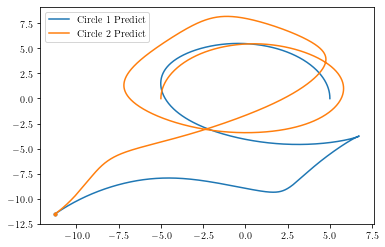

In [4]:
xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
              t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
              FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
              iter_no,Xcen2)
plotpreds(xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF)

### Inspect dynamics from random ICs

## FP1: (8.40164904466166,-12.024347515671723)

(8.401649023814034,-12.024347528020531)


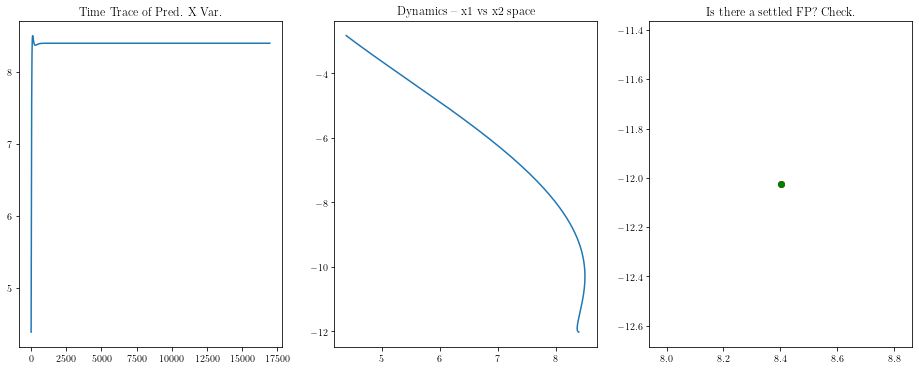

In [5]:
#rand_vecR1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('500rand_vecR1',rand_vecR1)
rand_vecR1 = loaddata('500rand_vecR1')
inspect_from_random_IC(rand_vecR1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

## FP2: (11.277100374014909,11.543403872838574)

(11.277100387663506,11.543403864483041)


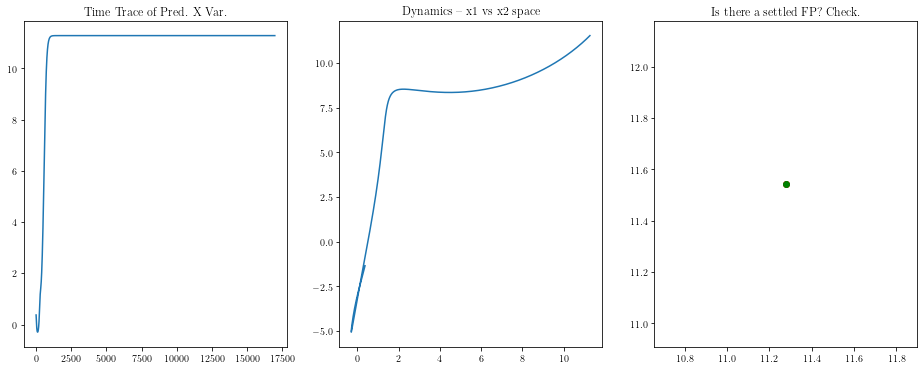

In [6]:
#rand_vecR2 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('500rand_vecR2',rand_vecR2)
rand_vecR2 = loaddata('500rand_vecR2')
inspect_from_random_IC(rand_vecR2,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

### How does FP1 evolve wrt $\rho$? BROADLY...

# FORWARD FP1

In [7]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# R1_0=np.empty([rho_steps,N]) #random starting pts
# FP1_0=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0 = np.empty([rho_steps,1])
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# xpr1_0, xpr2_0,R1_0,FP1_0,ErrCs1_0 = limitcycletracking(-rand_vecR1,R1_0,FP1_0,
#                        ErrCs1_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [8]:
# savedata('April500RandFP1_0_1500',FP1_0)
# savedata('April500RandErrCs1_0_1500',ErrCs1_0)

# display_results(FP1_0, ErrCs1_0)

In [9]:
FP1_0 = loaddata('April500RandFP1_0_1500')
ErrCs1_0 = loaddata('April500RandErrCs1_0_1500')
display_results(FP1_0, ErrCs1_0)

0      1                    2    3                    4  \
0                FP  444.0                  0.2  0.0   -5.964850114430823   
1                FP  444.0  0.20153435623749166  0.0  -28.005150921296185   
2                FP  444.0  0.20306871247498334  0.0  -27.797204010468086   
3                FP  444.0    0.204603068712475  0.0  -27.591542645841052   
4                FP  444.0  0.20613742494996665  0.0  -27.388147855083254   
5                FP  444.0  0.20767178118745833  0.0  -27.187000619260793   
6                FP  444.0  0.20920613742494998  0.0  -26.988081703866403   
7                FP  444.0  0.21074049366244163  0.0  -26.791371711794586   
8                FP  444.0   0.2122748498999333  0.0  -26.596851053575605   
9                FP  444.0  0.21380920613742496  0.0  -26.404499936298357   
10               FP  444.0  0.21534356237491661  0.0   -26.21429834554923   
11               FP  444.0   0.2168779186124083  0.0  -26.026226063496946   
12               FP  444.0  0.21841227484989995  0.0  -25.840262617131543   
13               FP  444.0   0.2199466310873916  0.0   -25.65638728911673   
14               FP  444.0  0.22148098732488328  0.0  -25.474579163625513   
15               FP  444.0  0.22301534356237493  0.0  -25.294817076035677   
16               FP  444.0  0.22454969979986658  0.0  -25.117079636007983   
17               FP  444.0  0.22608405603735826  0.0  -24.941345172488894   
18               FP  444.0   0.2276184122748499  0.0   -24.76759182612713   
19               FP  444.0  0.22915276851234156  0.0   -24.59579755284471   
20               FP  444.0  0.23068712474983322  0.0  -24.425939998754924   
21               FP  444.0   0.2322214809873249  0.0   -24.25799669910092   
22               FP  444.0  0.23375583722481655  0.0   -24.09194493921597   
23               FP  444.0  0.23529019346230823  0.0   -23.92776184118863   
24               FP  444.0  0.23682454969979988  0.0  -23.765424357177064   
25               FP  444.0  0.23835890593729153  0.0   -23.60490923571355   
26               FP  444.0  0.23989326217478318  0.0  -23.446193146241686   
27               FP  444.0  0.24142761841227486  0.0   -23.28925258350174   
28               FP  444.0  0.24296197464976652  0.0  -23.134063901132254   
29               FP  444.0   0.2444963308872582  0.0  -22.980603389974966   
30               FP  444.0  0.24603068712474985  0.0  -22.828847214713665   
31               FP  444.0   0.2475650433622415  0.0   -22.67877147239981   
32               FP  444.0  0.24909939959973315  0.0    -22.5303522035551   
33               FP  444.0   0.2506337558372248  0.0  -22.383565401549966   
34               FP  444.0   0.2521681120747165  0.0  -22.238386982048954   
35               FP  444.0  0.25370246831220816  0.0   -22.09479291189501   
36               FP  444.0   0.2552368245496998  0.0  -21.952759103834516   
37               FP  444.0  0.25677118078719147  0.0  -21.812261491686698   
38               FP  444.0   0.2583055370246831  0.0   -21.67327603991145   
39               FP  444.0  0.25983989326217477  0.0   -21.53577877001135   
40               FP  444.0   0.2613742494996665  0.0  -21.399745710028345   
41               FP  444.0  0.26290860573715813  0.0  -21.265152968453243   
42               FP  444.0   0.2644429619746498  0.0   -21.13197678914367   
43               FP  444.0  0.26597731821214143  0.0   -21.00019343574648   
44               FP  444.0   0.2675116744496331  0.0  -20.869779305675486   
45               FP  444.0  0.26904603068712474  0.0  -20.740710917584725   
46               FP  444.0   0.2705803869246164  0.0  -20.612964924968537   
47               FP  444.0   0.2721147431621081  0.0  -20.486518073762404   
48               FP  444.0  0.27364909939959975  0.0   -20.36134731897924   
49               FP  444.0   0.2751834556370914  0.0    -20.2374297598177   
50               FP  444.0  0.27671781187458305  0.0  -20.114742647926757   
51            

# BACKWARD FP1

In [10]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# R1_0rev=np.empty([rho_steps,N]) #random starting pts
# FP1_0rev=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0rev = np.empty([rho_steps,1])
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# xpr1_0, xpr2_0,R1_0rev,FP1_0rev,ErrCs1_0rev = limitcycletracking(-rand_vecR1,R1_0rev,FP1_0rev,
#                        ErrCs1_0rev,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [11]:
# savedata('April500RandFP1_0rev_1500',FP1_0rev)
# savedata('April500RandErrCs1_0rev_1500',ErrCs1_0rev)

# display_results(FP1_0rev, ErrCs1_0rev)

In [12]:
FP1_0rev = loaddata('April500RandFP1_0rev_1500')
ErrCs1_0rev = loaddata('April500RandErrCs1_0rev_1500')
display_results(FP1_0rev, ErrCs1_0rev)

0      1                    2    3                   4  \
0     Switch_chaos1    9.0                  2.5  0.0   8.600087903448701   
1     Switch_chaos1    9.0    2.498465643762508  0.0   8.971430694019059   
2     Switch_chaos1    9.0   2.4969312875250167  0.0   10.21115061124324   
3     Switch_chaos1    9.0    2.495396931287525  0.0   9.384897681794431   
4     Switch_chaos1    9.0   2.4938625750500334  0.0   11.71524169191091   
5     Switch_chaos1    9.0   2.4923282188125415  0.0   7.829115777227221   
6     Switch_chaos1    9.0     2.49079386257505  0.0    8.49214049899708   
7     Switch_chaos1    9.0    2.489259506337558  0.0   9.929035007444444   
8     Switch_chaos1    9.0    2.487725150100067  0.0  10.481735757511704   
9     Switch_chaos1    9.0    2.486190793862575  0.0   8.263318081268572   
10    Switch_chaos1    9.0   2.4846564376250835  0.0   9.892735881623654   
11    Switch_chaos1    9.0   2.4831220813875916  0.0   9.515369274337573   
12    Switch_chaos1    9.0      2.4815877251501  0.0   8.815163522314348   
13    Switch_chaos1    9.0   2.4800533689126083  0.0   9.496893668796448   
14    Switch_chaos1    9.0    2.478519012675117  0.0   8.652056770937234   
15    Switch_chaos1    9.0    2.476984656437625  0.0   7.757522362572991   
16    Switch_chaos1    9.0   2.4754503002001336  0.0   9.448516785303047   
17    Switch_chaos1    9.0   2.4739159439626417  0.0  10.068100962009742   
18    Switch_chaos1    9.0   2.4723815877251503  0.0  10.764688491455763   
19    Switch_chaos1    9.0   2.4708472314876584  0.0   7.265913142387174   
20    Switch_chaos1    9.0    2.469312875250167  0.0   9.366531365330395   
21    Switch_chaos1    9.0    2.467778519012675  0.0   9.662425195582191   
22    Switch_chaos1    9.0   2.4662441627751837  0.0   9.233002484241343   
23    Switch_chaos1    9.0    2.464709806537692  0.0  10.341536652676321   
24    Switch_chaos1    9.0   2.4631754503002004  0.0   8.373210923108008   
25    Switch_chaos1    9.0   2.4616410940627085  0.0   7.179112557420703   
26    Switch_chaos1    9.0   2.4601067378252166  0.0  10.048611204377753   
27    Switch_chaos1    9.0    2.458572381587725  0.0   8.335125446434363   
28    Switch_chaos1    9.0   2.4570380253502333  0.0   8.800136614755226   
29    Switch_chaos1    9.0    2.455503669112742  0.0   8.638229857123582   
30    Switch_chaos1    9.0     2.45396931287525  0.0   8.353918491566734   
31    Switch_chaos1    9.0   2.4524349566377586  0.0   9.838146729892525   
32    Switch_chaos1    9.0   2.4509006004002667  0.0   9.057889246696101   
33    Switch_chaos1    9.0   2.4493662441627753  0.0   8.298121394294881   
34    Switch_chaos1    9.0   2.4478318879252834  0.0   7.893740519547699   
35    Switch_chaos1    9.0    2.446297531687792  0.0   8.542670151682628   
36    Switch_chaos1    9.0      2.4447631754503  0.0   8.758602227528412   
37    Switch_chaos1    9.0   2.4432288192128087  0.0   8.793585923095218   
38    Switch_chaos1    9.0    2.441694462975317  0.0   8.047597784892739   
39    Switch_chaos1    9.0   2.4401601067378254  0.0   8.846311907771945   
40    Switch_chaos1    9.0   2.4386257505003335  0.0   6.891881323300569   
41    Switch_chaos1    9.0    2.437091394262842  0.0   8.133630766575836   
42    Switch_chaos1    9.0     2.43555703802535  0.0   9.097102607528388   
43    Switch_chaos1    9.0   2.4340226817878587  0.0   7.930857201616131   
44    Switch_chaos1    9.0    2.432488325550367  0.0   9.378404922346581   
45    Switch_chaos1    9.0   2.4309539693128754  0.0   9.482014308887358   
46    Switch_chaos1    9.0   2.4294196130753836  0.0   7.643655760566956   
47    Switch_chaos1    9.0    2.427885256837892  0.0    8.66054754295955   
48    Switch_chaos1    9.0   2.4263509006004003  0.0   7.296821481210806   
49    Switch_chaos1    9.0   2.4248165443629084  0.0   7.179124965081044   
50    Switch_chaos1    9.0    2.423282188125417  0.0  10.618086160469227   
51    Switch_chaos1    9.0    2.421747831887925  0.0   7.502579980

# FORWARD FP2

In [13]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# R2_0=np.empty([rho_steps,N]) #random starting pts
# FP2_0=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs2_0 = np.empty([rho_steps,1])
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# xpr1_0, xpr2_0,R2_0,FP2_0,ErrCs2_0 = limitcycletracking(-rand_vecR2,R2_0,FP2_0,
#                        ErrCs2_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [14]:
# savedata('April500RandFP2_0_1500',FP2_0)
# savedata('April500RandErrCs2_0_1500',ErrCs2_0)

# display_results(FP2_0, ErrCs2_0)

In [15]:
FP2_0 = loaddata('April500RandFP2_0_1500')
ErrCs2_0 = loaddata('April500RandErrCs2_0_1500')

display_results(FP2_0, ErrCs2_0)

0      1                    2    3                    4  \
0                FP  444.0                  0.2  0.0   -4.048770164267764   
1                FP  444.0  0.20153435623749166  0.0   -25.67616105879315   
2                FP  444.0  0.20306871247498334  0.0   -25.54486536363742   
3                FP  444.0    0.204603068712475  0.0  -25.414518733405764   
4                FP  444.0  0.20613742494996665  0.0  -25.285132089723096   
5                FP  444.0  0.20767178118745833  0.0  -25.156715525871693   
6                FP  444.0  0.20920613742494998  0.0  -25.029278174003565   
7                FP  444.0  0.21074049366244163  0.0   -24.90282842242141   
8                FP  444.0   0.2122748498999333  0.0    -24.7773736762117   
9                FP  444.0  0.21380920613742496  0.0    -24.6529205646972   
10               FP  444.0  0.21534356237491661  0.0  -24.529474736624387   
11               FP  444.0   0.2168779186124083  0.0  -24.407041036888575   
12               FP  444.0  0.21841227484989995  0.0  -24.285623416495483   
13               FP  444.0   0.2199466310873916  0.0  -24.165224933284755   
14               FP  444.0  0.22148098732488328  0.0    -24.0458478957269   
15               FP  444.0  0.22301534356237493  0.0   -23.92749370607711   
16               FP  444.0  0.22454969979986658  0.0  -23.810162993937464   
17               FP  444.0  0.22608405603735826  0.0  -23.693855536334915   
18               FP  444.0   0.2276184122748499  0.0  -23.578570392654875   
19               FP  444.0  0.22915276851234156  0.0  -23.464305851170526   
20               FP  444.0  0.23068712474983322  0.0  -23.351059378682596   
21               FP  444.0   0.2322214809873249  0.0  -23.238827823976266   
22               FP  444.0  0.23375583722481655  0.0  -23.127607292153943   
23               FP  444.0  0.23529019346230823  0.0  -23.017393278109708   
24               FP  444.0  0.23682454969979988  0.0  -22.908180549094904   
25               FP  444.0  0.23835890593729153  0.0  -22.799963291174432   
26               FP  444.0  0.23989326217478318  0.0   -22.69273512864053   
27               FP  444.0  0.24142761841227486  0.0   -22.58648907366179   
28               FP  444.0  0.24296197464976652  0.0  -22.481217589694506   
29               FP  444.0   0.2444963308872582  0.0   -22.37691265400221   
30               FP  444.0  0.24603068712474985  0.0  -22.273565793962867   
31               FP  444.0   0.2475650433622415  0.0  -22.171167974270574   
32               FP  444.0  0.24909939959973315  0.0   -22.06970981638238   
33               FP  444.0   0.2506337558372248  0.0    -21.9691815227371   
34               FP  444.0   0.2521681120747165  0.0   -21.86957282422573   
35               FP  444.0  0.25370246831220816  0.0  -21.770873208877404   
36               FP  444.0   0.2552368245496998  0.0     -21.673071794143   
37               FP  444.0  0.25677118078719147  0.0  -21.576157349954258   
38               FP  444.0   0.2583055370246831  0.0   -21.48011843817572   
39               FP  444.0  0.25983989326217477  0.0  -21.384943320493125   
40               FP  444.0   0.2613742494996665  0.0    -21.2906200006545   
41               FP  444.0  0.26290860573715813  0.0  -21.197136327915167   
42               FP  444.0   0.2644429619746498  0.0   -21.10447991092613   
43               FP  444.0  0.26597731821214143  0.0  -21.012638200005785   
44               FP  444.0   0.2675116744496331  0.0  -20.921598543632438   
45               FP  444.0  0.26904603068712474  0.0   -20.83134813083467   
46               FP  444.0   0.2705803869246164  0.0    -20.7418740366433   
47               FP  444.0   0.2721147431621081  0.0  -20.653163233295516   
48               FP  444.0  0.27364909939959975  0.0  -20.565202641301333   
49               FP  444.0   0.2751834556370914  0.0  -20.477979192772573   
50               FP  444.0  0.27671781187458305  0.0   -20.39147961907723   
51            

# BACKWARD FP2

In [16]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# R2_0rev=np.empty([rho_steps,N]) #random starting pts
# FP2_0rev=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs2_0rev = np.empty([rho_steps,1])
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# xpr1_0, xpr2_0,R2_0rev,FP2_0rev,ErrCs2_0rev = limitcycletracking(-rand_vecR2,R2_0rev,FP2_0rev,
#                        ErrCs2_0rev,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [17]:
# savedata('April500RandFP2_0rev_1500',FP2_0rev)
# savedata('April500RandErrCs2_0rev_1500',ErrCs2_0rev)

# display_results(FP2_0rev, ErrCs2_0rev)

In [18]:
FP2_0rev = loaddata('April500RandFP2_0rev_1500')
ErrCs2_0rev = loaddata('April500RandErrCs2_0rev_1500')

display_results(FP2_0rev, ErrCs2_0rev)

0      1                    2    3                   4  \
0     Switch_chaos1    9.0                  2.5  0.0   8.949275036427794   
1     Switch_chaos1    9.0    2.498465643762508  0.0    9.38679285212041   
2     Switch_chaos1    9.0   2.4969312875250167  0.0   9.984172416873903   
3     Switch_chaos1    9.0    2.495396931287525  0.0   8.783028069440567   
4     Switch_chaos1    9.0   2.4938625750500334  0.0   8.709096798747057   
5     Switch_chaos1    9.0   2.4923282188125415  0.0   7.443651867663337   
6     Switch_chaos1    9.0     2.49079386257505  0.0   8.667784507447536   
7     Switch_chaos1    9.0    2.489259506337558  0.0    8.48233104444821   
8     Switch_chaos1    9.0    2.487725150100067  0.0   9.573241677729499   
9     Switch_chaos1    9.0    2.486190793862575  0.0    7.68166953317589   
10    Switch_chaos1    9.0   2.4846564376250835  0.0   7.692178262904659   
11    Switch_chaos1    9.0   2.4831220813875916  0.0  10.250992170622954   
12    Switch_chaos1    9.0      2.4815877251501  0.0   9.838360960285812   
13    Switch_chaos1    9.0   2.4800533689126083  0.0   7.824377291503635   
14    Switch_chaos1    9.0    2.478519012675117  0.0   8.626903777390327   
15    Switch_chaos1    9.0    2.476984656437625  0.0   8.721758385519182   
16    Switch_chaos1    9.0   2.4754503002001336  0.0  10.105678892895023   
17    Switch_chaos1    9.0   2.4739159439626417  0.0   9.771342812637213   
18    Switch_chaos1    9.0   2.4723815877251503  0.0   9.156101203566848   
19    Switch_chaos1    9.0   2.4708472314876584  0.0   6.696957268801135   
20    Switch_chaos1    9.0    2.469312875250167  0.0   8.851484341949932   
21    Switch_chaos1    9.0    2.467778519012675  0.0   9.671333056292116   
22    Switch_chaos1    9.0   2.4662441627751837  0.0   8.453193092844094   
23    Switch_chaos1    9.0    2.464709806537692  0.0   8.925384291791621   
24    Switch_chaos1    9.0   2.4631754503002004  0.0  12.020759372285887   
25    Switch_chaos1    9.0   2.4616410940627085  0.0   7.357385587339431   
26    Switch_chaos1    9.0   2.4601067378252166  0.0   9.913584232575635   
27    Switch_chaos1    9.0    2.458572381587725  0.0   7.426494331648031   
28    Switch_chaos1    9.0   2.4570380253502333  0.0   9.257844687498912   
29    Switch_chaos1    9.0    2.455503669112742  0.0   9.302653012879883   
30    Switch_chaos1    9.0     2.45396931287525  0.0   9.211919575548727   
31    Switch_chaos1    9.0   2.4524349566377586  0.0    9.78896699881445   
32    Switch_chaos1    9.0   2.4509006004002667  0.0    8.10409775747727   
33    Switch_chaos1    9.0   2.4493662441627753  0.0   8.306425685664808   
34    Switch_chaos1    9.0   2.4478318879252834  0.0   8.327383262354529   
35    Switch_chaos1    9.0    2.446297531687792  0.0   8.655675694198353   
36    Switch_chaos1    9.0      2.4447631754503  0.0   7.703886625093269   
37    Switch_chaos1    9.0   2.4432288192128087  0.0   9.238868214430468   
38    Switch_chaos1    9.0    2.441694462975317  0.0   8.921237478685022   
39    Switch_chaos1    9.0   2.4401601067378254  0.0   8.260156174375659   
40    Switch_chaos1    9.0   2.4386257505003335  0.0   9.603581762040596   
41    Switch_chaos1    9.0    2.437091394262842  0.0   8.445943107016456   
42    Switch_chaos1    9.0     2.43555703802535  0.0   7.586858090137995   
43    Switch_chaos1    9.0   2.4340226817878587  0.0   9.452485987803371   
44    Switch_chaos1    9.0    2.432488325550367  0.0    8.55285181922852   
45    Switch_chaos1    9.0   2.4309539693128754  0.0   8.874296678565754   
46    Switch_chaos1    9.0   2.4294196130753836  0.0   8.097680575618037   
47    Switch_chaos1    9.0    2.427885256837892  0.0   8.633224028689966   
48    Switch_chaos1    9.0   2.4263509006004003  0.0    9.89307109130172   
49    Switch_chaos1    9.0   2.4248165443629084  0.0   7.772611467404699   
50    Switch_chaos1    9.0    2.423282188125417  0.0  10.303324923847027   
51    Switch_chaos1    9.0    2.421747831887925  0.0   8.328535117

### Now, in detail, get FP, LC and C's for FP1.

### FP for FP1

In [19]:
# rho_max=0.75
# rho_min=0.2
# rho_steps=100
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_1=np.empty([rho_steps,N]) 
# FP1_1=np.empty([rho_steps,4])
# xpr1_1, xpr2_1, rho_1, FP1_1, R1_1 = inspect_from_random_IC_for_multiple_rho(
#                                      -rand_vecR1,rhospace,Minit,xcen,dt,t_time,
#                                      ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
#                                      dd2,omega2,gama,sigma,alpha,beta,xy_1,
#                                      PredictEndTime,Xcen1,FP_err_lim,R1_1,
#                                      FP1_1)

In [20]:
# save the FP data for the 3d plot
#savedata('500RandFP1_1',FP1_1[0:60,:])
FP1_1 = loaddata('500RandFP1_1')
# print(FP1_1)

# save the limit cycle plot for 3d...
z_values = np.linspace(0.53, 0.65, 20)
# LCdatax = xpr1_1[3000:]; LCdatay = xpr2_1[3000:]
# savedata('500RandFP1_LC1x',LCdatax); savedata('500RandFP1_LC1y',LCdatay)
LCdatax = loaddata('500RandFP1_LC1x'); LCdatay = loaddata('500RandFP1_LC1y')

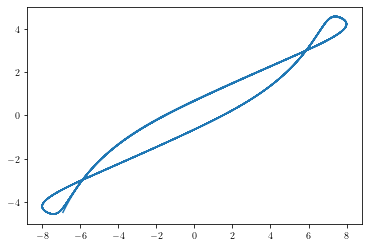

In [21]:
plt.plot(LCdatax,LCdatay)

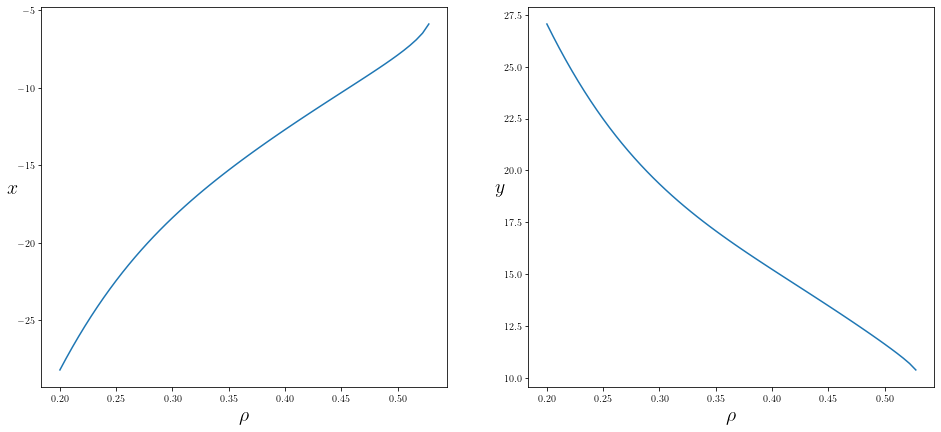

In [22]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

### FP for FP2

In [23]:
# note, regardless of the FP I start from, results in the same single limit cycle.

In [24]:
# rho_max=0.65
# rho_min=0.5
# rho_steps=100
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_1=np.empty([rho_steps,N]) 
# FP2_1=np.empty([rho_steps,4])
# # start from random vec leading to (8.011575394768629,11.948578613390712)
# xpr1_2, xpr2_2, rho_2, FP2_1, R2_1 = inspect_from_random_IC_for_multiple_rho(
#                                      -rand_vecR2,rhospace,Minit,xcen,dt,t_time,
#                                      ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
#                                      dd2,omega2,gama,sigma,alpha,beta,xy_1,
#                                      PredictEndTime,Xcen1,FP_err_lim,R2_1,
#                                      FP2_1)

In [25]:
# print(f'stops tracking at {rho_2}')
# plt.plot(xpr1_2, xpr2_2)

In [26]:
# save the FP data for the 3d plot
#savedata('500RandFP2_1',FP2_1[0:60,:])
FP2_1 = loaddata('500RandFP2_1')
#print(FP2_1)

# save the limit cycle plot for 3d...
z_valuesLC2 = np.linspace(0.53, 0.65, 50)
# LC2datax = xpr1_2[3000:]; LC2datay = xpr2_2[3000:]
# savedata('500RandFP2_LC1x',LC2datax); savedata('500RandFP2_LC1y',LC2datay)
LC2datax = loaddata('500RandFP2_LC1x'); LC2datay = loaddata('500RandFP2_LC1y')

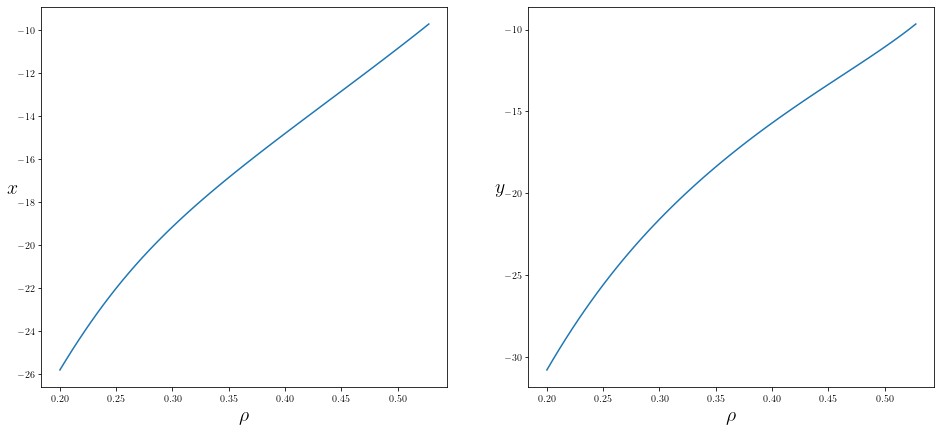

In [27]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP2_1.T[0],FP2_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP2_1.T[0],FP2_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

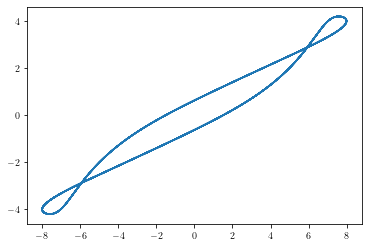

In [28]:
plt.plot(LC2datax,LC2datay)

### Get circle plots...

In [29]:
# save the limit cycle plot for 3d...
z_valuesCAd1 = np.linspace(0.94, 1.19, 20)
z_valuesCAd2 = np.linspace(1.55, 1.65, 20)
z_valuesCBd1 = np.linspace(1.27, 1.55, 40)
z_valuesCB = np.linspace(1.65, 1.83, 30) #clean
z_valuesSw1 = np.linspace(.65, .94, 30) 
z_valuesSw2 = np.linspace(1.19, 1.27, 30)
z_valuesSw3 = np.linspace(1.83, 2.5, 30)

CAdatax = loaddata('FP1_CA1x'); CAdatay = loaddata('FP1_CA1y')
CBdatax = loaddata('FP1_CB1x'); CBdatay = loaddata('FP1_CB1y')
Cdirnx = loaddata('Cx_dirnonly');Cdirny = loaddata('Cy_dironly') 
Switchx = loaddata('switchx');Switchy = loaddata('switchy') 
#multistability regions... None here
# z_valuesMS = np.linspace(.83, .99, 50)
# z_valuesMS2 = np.linspace(1.02, 1.63, 50)

# r = 2.5  # radius
# theta = np.linspace(0, 2*np.pi, 100)  # angles
# xMS = r * np.cos(theta)  # x coordinates
# yMS = r * np.sin(theta)  # y coordinates
# plt.plot(xMS,yMS)
# savedata('Cx_dirnonly',xMS); savedata('Cy_dironly',yMS)

### Sanity check at rho 1.6... not MF

In [30]:
# rho_max=1.6
# rho_min=rho_max
# rho_steps=1
# rhospace=np.linspace(rho_min,rho_max,rho_steps)

# x1C1_MF,x2C1_MF,x1C2_MF,x2C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
#               t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
#               FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
#               iter_no,Xcen2)

# plt.plot(x1C1_MF,x2C1_MF)
# plt.plot(x1C1_MF[-10],x2C1_MF[-10],'go')
# plt.plot(x1C1_MF[-1],x2C1_MF[-1],'ro')
# plt.plot(x1C2_MF,x2C2_MF)
# plt.plot(x1C2_MF[-10],x2C2_MF[-10],'go')
# plt.plot(x1C2_MF[-1],x2C2_MF[-1],'ro')

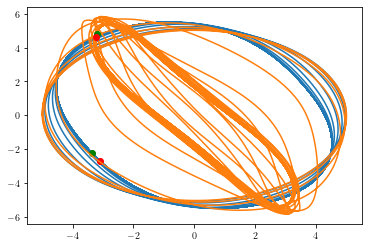

In [31]:
# save this for later...
# savedata('NoMFrho16_Rand_x1C1_MF',x1C1_MF)
# savedata('NoMFrho16_Rand_x2C1_MF',x2C1_MF)
# savedata('NoMFrho16_Rand_x1C2_MF',x1C2_MF)
# savedata('NoMFrho16_Rand_x2C2_MF',x2C2_MF)
x1C1_MF = loaddata('NoMFrho16_Rand_x1C1_MF')
x2C1_MF = loaddata('NoMFrho16_Rand_x2C1_MF')
x1C2_MF = loaddata('NoMFrho16_Rand_x1C2_MF')
x2C2_MF = loaddata('NoMFrho16_Rand_x2C2_MF')

plt.plot(x1C1_MF,x2C1_MF)
plt.plot(x1C1_MF[-10],x2C1_MF[-10],'go')
plt.plot(x1C1_MF[-1],x2C1_MF[-1],'ro')
plt.plot(x1C2_MF,x2C2_MF)
plt.plot(x1C2_MF[-10],x2C2_MF[-10],'go')
plt.plot(x1C2_MF[-1],x2C2_MF[-1],'ro')

## 3D plot simple...

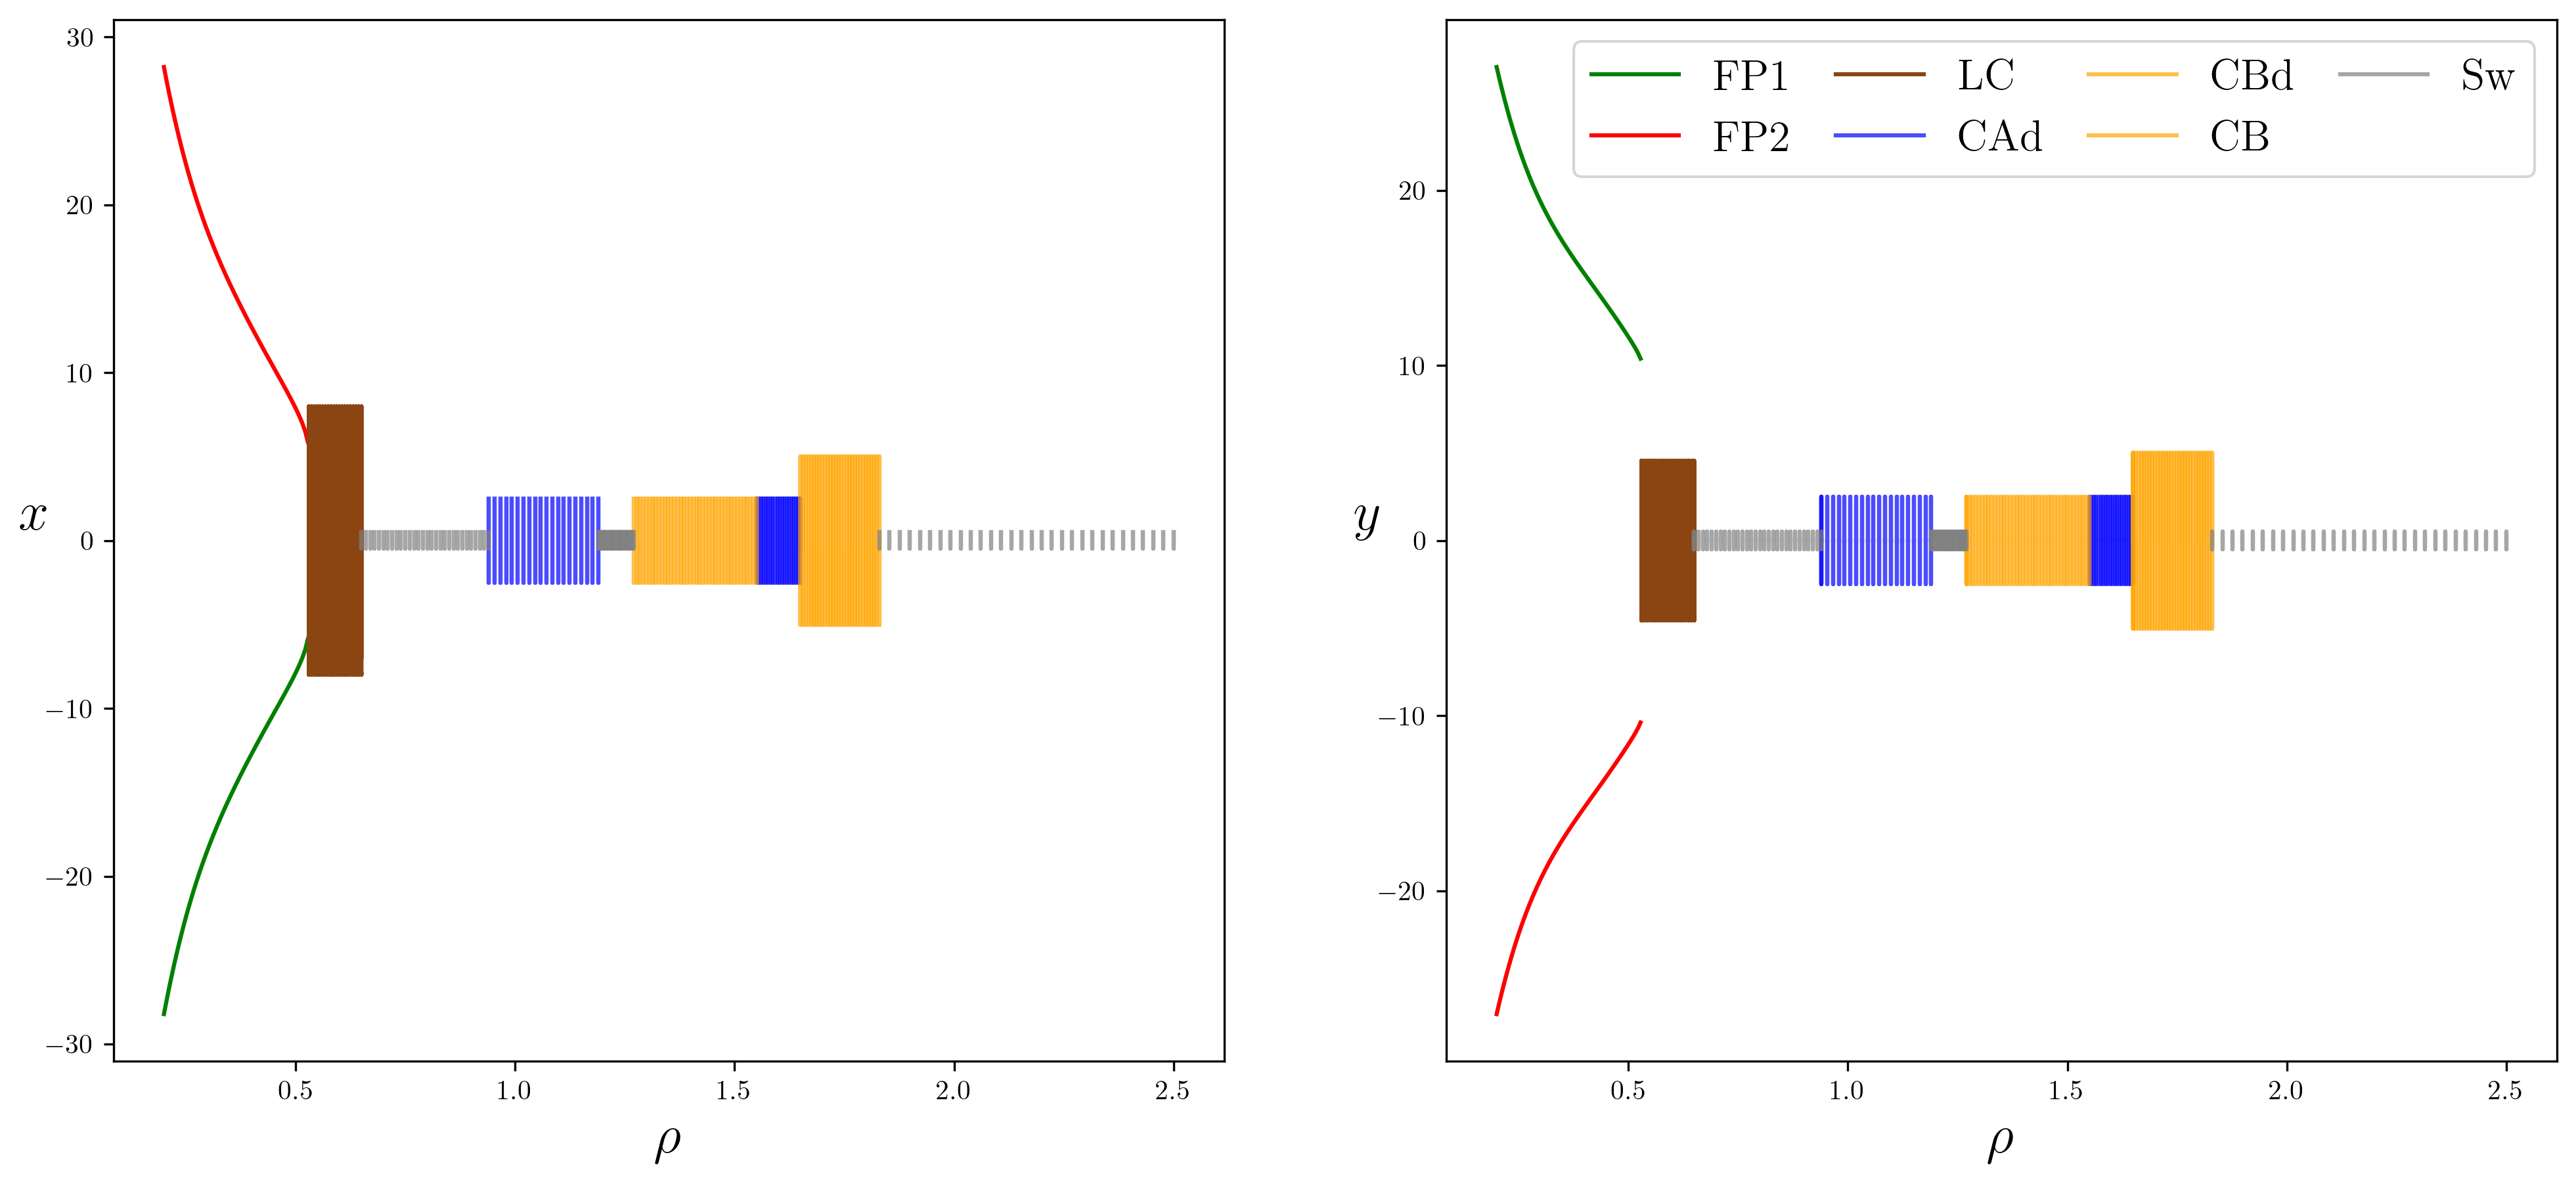

In [32]:
plt.figure(figsize=(16,7),dpi=300)
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2],'g')
plt.plot(FP1_1.T[0],-FP1_1.T[2],'r')
for z in z_values:
    plt.plot(z*np.ones_like(LCdatax),LCdatax, 'saddlebrown')
for z in z_valuesCAd1:
    plt.plot(z*np.ones_like(Cdirnx),Cdirnx, 'blue', alpha=0.7)
for z in z_valuesCAd2:
    plt.plot(z*np.ones_like(Cdirnx),Cdirnx, 'blue', alpha=0.7)    
for z in z_valuesCBd1:
    plt.plot(z*np.ones_like(Cdirnx),Cdirnx, 'orange', alpha=0.7)
for z in z_valuesCB:
    plt.plot(z*np.ones_like(CBdatax),CBdatax, 'orange', alpha=0.7)
for z in z_valuesSw1:
    plt.plot(z*np.ones_like(Switchx),Switchx, 'grey', alpha=0.7)
for z in z_valuesSw2:
    plt.plot(z*np.ones_like(Switchx),Switchx, 'grey', alpha=0.7)    
for z in z_valuesSw3:
    plt.plot(z*np.ones_like(Switchx),Switchx, 'grey', alpha=0.7) 

plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3],'g', label=r'FP1')
plt.plot(FP1_1.T[0],-FP1_1.T[3],'r', label=r'FP2')
for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown', label='LC')        
    plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown')
for z in enumerate(z_valuesCAd1):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(Cdirny),Cdirny, 'blue', alpha=0.7,label='CAd')
    plt.plot(z[1]*np.ones_like(Cdirny),Cdirny, 'blue', alpha=0.7)
for z in z_valuesCAd2:
    plt.plot(z*np.ones_like(Cdirny),Cdirny, 'blue', alpha=0.7) 
for z in enumerate(z_valuesCBd1):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(Cdirny),Cdirny, 'orange', alpha=0.7,label='CBd')
    plt.plot(z[1]*np.ones_like(Cdirny),Cdirny, 'orange', alpha=0.7)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7,label='CB')
    plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7)
for z in enumerate(z_valuesSw1):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(Switchy),Switchy, 'grey', alpha=0.7,label='Sw')
    plt.plot(z[1]*np.ones_like(Switchy),Switchy, 'grey', alpha=0.7)
for z in z_valuesSw2:
    plt.plot(z*np.ones_like(Switchy),Switchy, 'grey', alpha=0.7)
for z in z_valuesSw3:
    plt.plot(z*np.ones_like(Switchy),Switchy, 'grey', alpha=0.7) 
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.legend(loc='upper right',ncol=4,fontsize=16,handlelength=2,columnspacing=1)
plt.show()

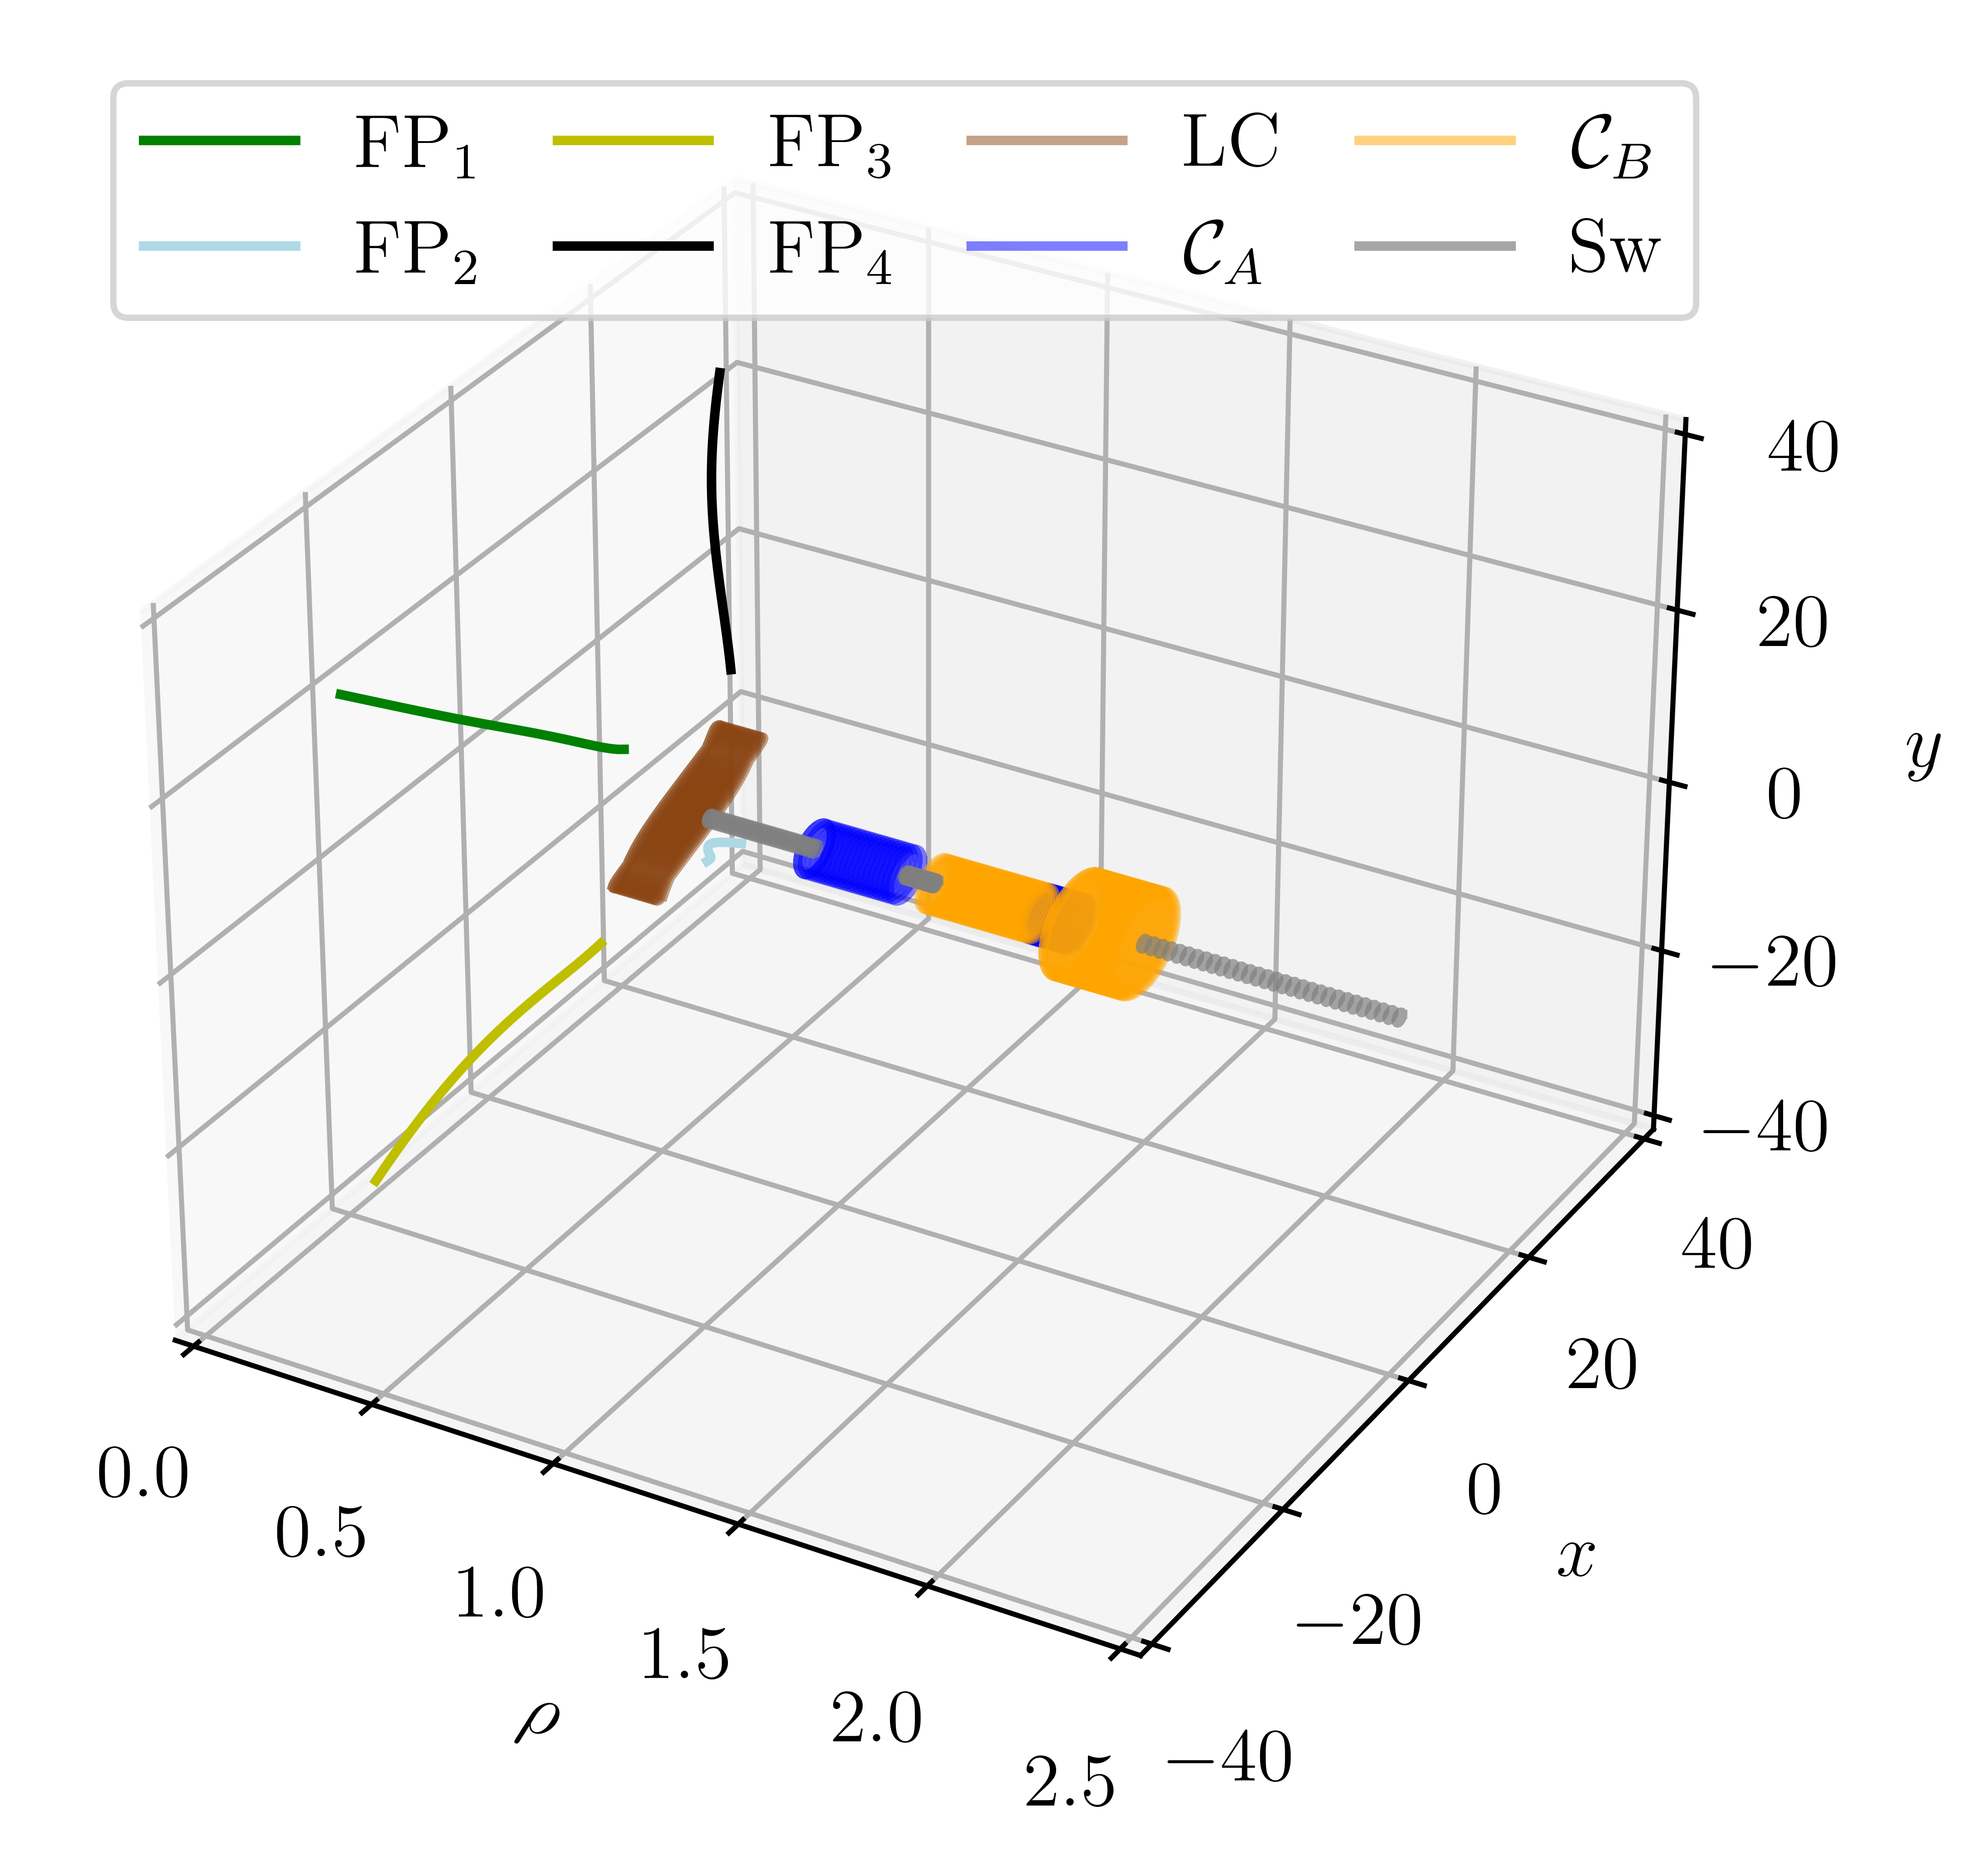

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D axes object
fig = plt.figure(figsize=(11,5),dpi=1000)
ax = fig.add_subplot(111, projection='3d')

# plot in 3d
plt.plot(FP1_1.T[0],FP1_1.T[2],FP1_1.T[3],'g', label=r'FP${}_1$')
plt.plot(FP1_1.T[0],-FP1_1.T[2],-FP1_1.T[3],'lightblue', label=r'FP${}_2$')
plt.plot(FP2_1.T[0],FP2_1.T[2],FP2_1.T[3],'y', label=r'FP${}_3$')
plt.plot(FP2_1.T[0],-FP2_1.T[2],-FP2_1.T[3],'black', label=r'FP${}_4$')

for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatax),LCdatax, LCdatay,alpha=0.5,color='saddlebrown',label=r'LC')        
    plt.plot(z[1]*np.ones_like(LCdatax),LCdatax,LCdatay, alpha=0.5,color='saddlebrown')
for z in enumerate(z_valuesCAd1):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(Cdirnx),Cdirnx,Cdirny, 'blue', alpha=0.5,label=r'$\mathcal{C}_{A}$')
    plt.plot(z[1]*np.ones_like(Cdirnx),Cdirnx, Cdirny,'blue', alpha=0.5)
for z in enumerate(z_valuesCAd2):
    plt.plot(z[1]*np.ones_like(Cdirnx),Cdirnx, Cdirny,'blue', alpha=0.5)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatax),CBdatax,CBdatay, 'orange', alpha=0.5,label=r'$\mathcal{C}_{B}$')
    plt.plot(z[1]*np.ones_like(CBdatax),CBdatax, CBdatay,'orange', alpha=0.5)
for z in enumerate(z_valuesCBd1):
    plt.plot(z[1]*np.ones_like(Cdirnx),Cdirnx, Cdirny,'orange', alpha=0.5)
for z in enumerate(z_valuesSw1):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(Switchx),Switchx, Switchy, 'grey', alpha=0.7,label='Sw')
    plt.plot(z[1]*np.ones_like(Switchx),Switchx, Switchy, 'grey', alpha=0.7)
for z in enumerate(z_valuesSw2):
    plt.plot(z[1]*np.ones_like(Switchx),Switchx, Switchy, 'grey', alpha=0.7)
for z in enumerate(z_valuesSw3):
    plt.plot(z[1]*np.ones_like(Switchx),Switchx, Switchy, 'grey', alpha=0.7)

# Set labels for the axes
ax.set_xlabel(r'$\rho$',fontsize=12)
ax.set_ylabel(r'$x$',fontsize=12)
ax.set_zlabel(r'$y$',fontsize=12)

# Adjust font size of axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, 2.5])
ax.set_ylim([-40, 40])
ax.set_zlim([-40, 40])
plt.legend(loc='upper center',ncol=4,fontsize=12,handlelength=2,columnspacing=1)

# Show the plot
plt.show()